### Importing the libraries

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [115]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [116]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Importing the MNIST dataset

In [117]:
#MNIST Image --> Tensors

In [118]:
transform = transforms.ToTensor()

In [119]:
train_data = datasets.MNIST(root='../Data',train=True, download = True,transform=transform)

In [120]:
test_data = datasets.MNIST(root='../Data',train=False, download = True,transform=transform)

In [121]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [122]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [123]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [124]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

We notice that it is a two item tuple. First item - 28 x 28 image pixel values, second item is the label associated with it

In [125]:
image , label = train_data[0]

In [126]:
image.shape

torch.Size([1, 28, 28])

Since it is grayscale , number of colour channels = 1

In [127]:
label

5

While using imshow make sure to reshape the image in order to remove the color channels dimension . (1,28,28) --> (28,28)

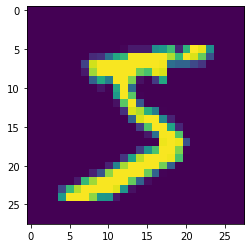

In [128]:
plt.imshow(image.reshape((28,28)))

To view it in grayscale

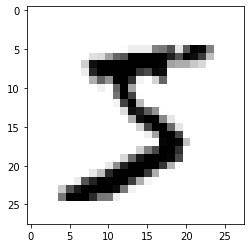

In [129]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg')

In [130]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

## Viewing a batch of images

In [131]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

In [132]:
for images,labels in train_loader:
    break
#Since we need only the first batch, we break the for loop once the first batch is obtained

images within trainloader have shape [batch_size, color_channels,width,height]

In [133]:
type(images)

torch.Tensor

In [134]:
labels.shape

torch.Size([100])

Print the first 12 images along with the labels

Labels: [   7    2    3    5    8    5    3    6    9    9    1    3]


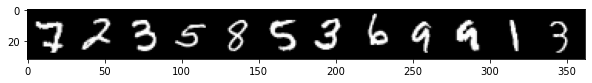

In [135]:
print('Labels:',labels[:12].numpy())
im = make_grid(images[:12],nrow=12)
plt.figure(figsize=(10,4))
#We need to transpose the images from CWH(color channels - width - height) to WHC
plt.imshow(np.transpose(im.numpy(),(1,2,0)))


In [136]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self,in_sz = 784, out_sz =10,layers=[120,84]):
        super().__init__()

        layer_list =[]

        for i in layers:
            layer_list.append(nn.Linear(in_sz,i))
            layer_list.append(nn.ReLU(inplace=True))
            in_sz = i
        layer_list.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layer_list)

    
    def forward(self,x):
        X = self.layers(x)
        return F.log_softmax(X,dim=1) #Multi class classification

In [137]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

When we move from ANN to CNN we notice that there is a significant reduction in the number of parameters hence ensuring a more efficient workflow

In [138]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [139]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

#### Flatten the images

Flattening out the images obtained through dataloader
[batch_size,C,W,H]   ---> [batch_size , C*W*H]


In [140]:
images.view(100,-1).shape

torch.Size([100, 784])

Doing this will keep the specified dimension intact(batch size in this case) while flattening out the remaining dimensions

### Training and evaluation

In [142]:
import time
start_time = time.time()

#Training
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    test_corr =0

    for b, (X_train,y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            acc = trn_corr.item()*100 /(100*b)
            print(f'Epoch: {i} \t batch: {b} \t loss{loss.item()} accuracy:{acc}')
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1))

            predicted = torch.max(y_val.data,1)[1]
            test_corr += (predicted==y_test).sum()

    loss =  criterion(y_val,y_test)    
    test_losses.append(loss.item())
    test_correct.append(test_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} minutes')

Epoch: 0 	 batch: 200 	 loss0.11684545874595642 accuracy:97.52
Epoch: 0 	 batch: 400 	 loss0.013143344782292843 accuracy:97.59
Epoch: 0 	 batch: 600 	 loss0.0728127658367157 accuracy:97.55666666666667
Epoch: 1 	 batch: 200 	 loss0.04194854572415352 accuracy:98.11
Epoch: 1 	 batch: 400 	 loss0.06593006104230881 accuracy:98.02
Epoch: 1 	 batch: 600 	 loss0.0550549142062664 accuracy:98.04666666666667
Epoch: 2 	 batch: 200 	 loss0.09487462788820267 accuracy:98.605
Epoch: 2 	 batch: 400 	 loss0.018234897404909134 accuracy:98.4675
Epoch: 2 	 batch: 600 	 loss0.043376900255680084 accuracy:98.38666666666667
Epoch: 3 	 batch: 200 	 loss0.027965476736426353 accuracy:98.895
Epoch: 3 	 batch: 400 	 loss0.045210547745227814 accuracy:98.8075
Epoch: 3 	 batch: 600 	 loss0.016074422746896744 accuracy:98.765
Epoch: 4 	 batch: 200 	 loss0.009635777212679386 accuracy:99.01
Epoch: 4 	 batch: 400 	 loss0.014760114252567291 accuracy:98.96
Epoch: 4 	 batch: 600 	 loss0.03266115486621857 accuracy:98.913333333

Plotting out the losses

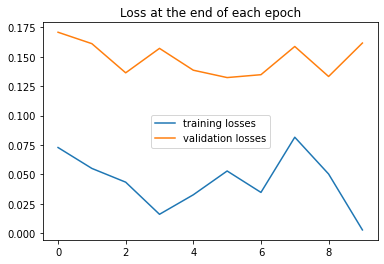

In [143]:
plt.plot(train_losses,label='training losses')
plt.plot(test_losses,label='validation losses')
plt.title('Loss at the end of each epoch')
plt.legend();

In [144]:
train_acc = [ t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

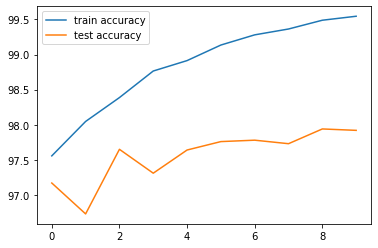

In [145]:
plt.plot(train_acc,label='train accuracy')
plt.plot(test_acc,label='test accuracy')
plt.legend();

In [146]:
# New unseen data

test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [148]:
with torch.no_grad():
    correct = 0

    for (X_test,y_test) in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == y_test).sum()

In [149]:
100*correct.item()/len(test_data)

97.92

In [150]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 974,    0,    4,    2,    1,    2,    6,    0,    4,    3],
       [   0, 1125,    1,    0,    0,    0,    2,    5,    0,    2],
       [   0,    4, 1009,    5,    1,    0,    2,    7,    5,    0],
       [   0,    0,    3,  990,    0,   11,    1,    1,    8,    5],
       [   1,    0,    2,    0,  954,    2,    3,    1,    1,    3],
       [   0,    0,    0,    4,    2,  867,    9,    1,    3,    3],
       [   1,    2,    2,    0,    5,    1,  935,    0,    1,    0],
       [   1,    1,    5,    5,    1,    1,    0, 1009,    4,    5],
       [   3,    3,    6,    3,    3,    6,    0,    1,  946,    5],
       [   0,    0,    0,    1,   15,    2,    0,    3,    2,  983]],
      dtype=int64)